In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

Text(0, 0.5, 'Duration')

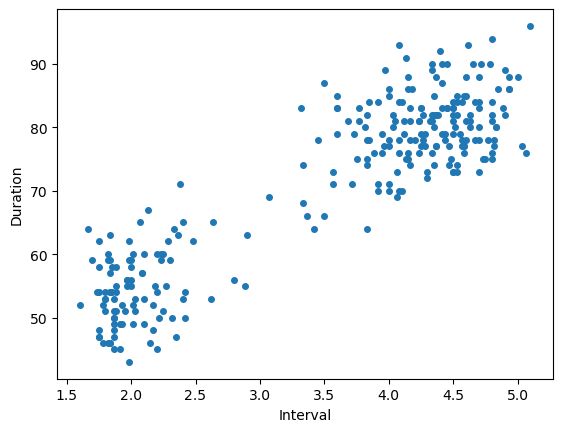

In [2]:
data = pd.read_table("faithful.dat", sep="\s+", index_col=0)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')


In [3]:
gm = GaussianMixture(n_components=2, covariance_type='diag').fit(data)


Text(0, 0.5, 'Duration')

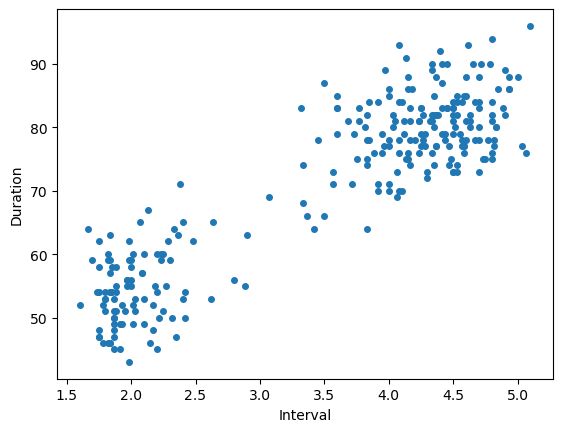

In [4]:
x = np.linspace(1.0, 5.5)
y = np.linspace(40.0, 100.0)
X, Y = np.meshgrid(x, y)
XY = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XY)
Z = Z.reshape(X.shape)

# plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
#             levels=np.logspace(0, 3, 20), alpha=0.5)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')

In [5]:
Z.shape

(50, 50)

In [6]:
data.shape
np.linspace(1.0, 5.5).shape

(50,)

In [7]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, random_state=0).fit(data)
print(gm.means_)
#gm.predict([[0, 0], [12, 3]])
print(gm.predict(X))
print(gm.predict([[4, 75], [2, 50], [4.2, 82], [2.4, 60]]))

[[ 4.28977944 79.96953298]
 [ 2.03652149 54.47986018]]
[1 1 1 0 0 0]
[0 1 0 1]


In [13]:
gm = GaussianMixture(n_components=2, random_state=0, max_iter=10).fit(data)
print(gm.means_)
print(gm.weights_)
print(gm.converged_)

[[ 4.28977944 79.96953298]
 [ 2.03652149 54.47986018]]
[0.64407255 0.35592745]
True


In [14]:
gm = GaussianMixture(n_components=3, random_state=0, max_iter=400).fit(data)
print(gm.means_)
print(gm.weights_)
print(gm.converged_)

[[ 4.28075504 76.02678163]
 [ 2.03312329 54.44576977]
 [ 4.29235569 83.62497808]]
[0.31368335 0.35451584 0.33180081]
True


In [10]:
data.to_numpy().shape

(272, 2)

In [11]:
def myEM(X, G, itmax, prob, mean, sigma):
    loglik_val = None
    prob_new = None
    mean_new = None 
    sigma_new = None
    for i in range(itmax):
        
        prob_new = prob
        mean_new = mean 
        sigma_new = sigma
        
        Z = Estep_v2(X=X, G=G, prob=prob, mean=mean, sigma=sigma)
        #Mstep()
        (prob_new, mean_new, sigma_new) = Mstep(X=X, G=G, prob=prob, mean=mean, sigma=sigma, Z=Z)
        #print(X)

        loglik_val = loglik_v1(X=X, G=G, prob=prob_new, mean=mean_new, sigma=sigma_new, Z=Z)
        
        prob = prob_new
        mean = mean_new 
        sigma = sigma_new
        
    return (prob_new, mean_new, sigma_new, loglik_val)

myEM(X=data.to_numpy(), G=G, itmax=200, prob=prob, mean=mean, sigma=sigma)

NameError: name 'G' is not defined

In [ ]:
def Estep(X, G, prob, mean, sigma):
    p = np.zeros([G, X.shape[0]])
    for i in range(G):
        prob_tmp = prob[i]
        mean_tmp = mean[i]
        p_tmp = multivariate_normal.pdf(X, mean=mean_tmp, cov=sigma);
        p_tmp = p_tmp * prob_tmp
        
        p[i] = p_tmp
    
    p = p / np.sum(p, axis=0)

    return p

Z = Estep(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma)
Z

In [ ]:
def Estep_v2(X, G, prob, mean, sigma):
    p = np.zeros([G, X.shape[0]])
    
    eq1 = prob[:, np.newaxis]
    
    sigma_det = np.linalg.det(sigma)
    
    A = X.T
    A_minus_mean = (A[np.newaxis, :, :] - mean[:, :, np.newaxis])
    eq3 = (np.linalg.inv(sigma) @ A_minus_mean) * A_minus_mean
    eq3 = -0.5 * np.sum(eq3, axis=1)
    eq3 = np.exp(eq3) / (2 * np.pi * np.sqrt(sigma_det))
    
    p = eq1 * eq3
    #print(eq3[0] > eq3[1])
    #print(eq3.shape)
    p = p / np.sum(p, axis=0)
    return p
    
Z = Estep_v2(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma)
#Z

In [ ]:
def Mstep(X, G, prob, mean, sigma, Z):
    n = X.shape[0]
    
    prob_new = None
    mean_new = None
    sigma_new = None
    
    prob_new = np.mean(Z, axis=1)
    
    print(f"prob={prob}")
    print(f"prob_new={prob_new}")
    
    mean_new = np.sum(Z[:, :, np.newaxis] * X, axis = 1) / np.sum(Z[:, :, np.newaxis], axis = 1)
    
    print(f"mean={mean}")
    print(f"mean_new={mean_new}")
    #print(f"mean_new.shape={mean_new.shape}")

    sigma_new = sigma
    
    a1 = (X[np.newaxis, :, :] - mean_new[:, np.newaxis, :]) * prob_new[:, np.newaxis, np.newaxis]
    a2 = (X.T[np.newaxis, :, :] - mean_new[:, :, np.newaxis] ) * prob_new[:, np.newaxis, np.newaxis]
    m1 = np.matmul(a2, a1)
    #m1 = prob_new[:, np.newaxis]
    sigma_new = np.sum(m1, axis=0) / n
    
    print(f"sigma={sigma}")
    print(f"sigma_new={sigma_new}")
    
    return (prob_new, mean_new, sigma_new)

Mstep(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma, Z=Z)

#Z.shape

In [ ]:
def loglik_v1(X, G, prob, mean, sigma, Z):
    p = np.zeros([X.shape[0]])
    print(prob)
    for i in range(G):
        prob_tmp = prob[i]
        mean_tmp = mean[i]
        p_tmp = multivariate_normal.pdf(X, mean=mean_tmp, cov=sigma);
        #print(p_tmp)
        p_tmp = p_tmp * prob_tmp
        #print("++++++++")
        #print(p_tmp)
        #print("========")
        p = p + p_tmp
        #print(f"p={p}")
        #print(f"p={np.sum(p)}")
        
    #print(p)
    #print(np.log(p))
    #print(np.sum(np.log(p)))
    loglik_val = np.sum(np.log(p))
    
    print(f"loglik_val={loglik_val}")
    return loglik_val

loglik_v1(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma, Z=Z)

In [ ]:
def loglik_v2(X, G, prob, mean, sigma, Z=Z):
    #print(Z)
    eq1 = np.log(prob[:, np.newaxis])    
#     print(f"eq1={eq1}")
    
    sigma_det = np.array([np.linalg.det(sigma)])[np.newaxis, :]
    eq2 = 0.5 * np.log(sigma_det)
    
#     print(f"eq2={eq2}")
#     print(f"eq1-eq2={eq1 - eq2}")
#     print(f"np.sum(eq1 - eq2)={np.sum(eq1 - eq2)}")
    
    #eq3 = 1 * 0.5*np.sum((X[np.newaxis, :, :] - mean[:, np.newaxis, :])**2, axis=2)
    A = X.T
    A_minus_mean = (A[np.newaxis, :, :] - mean[:, :, np.newaxis])
    #print(A_mean.shape)
    eq3 = (np.linalg.inv(sigma) @ A_minus_mean) * A_minus_mean
    eq3 = 0.5 * np.sum(eq3, axis=1) 
    #print(eq3.shape)

    final = eq1 - eq2 - eq3
    #print(final.shape)
    
    #final = final * mask
    
    #print(final)
    #print(np.sum(final))
    loglik_val = np.sum(final)
    print(f"loglik_val={loglik_val}")
    return loglik_val

loglik_v2(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma, Z=Z)



In [ ]:
def loglik_v3(X, G, prob, mean, sigma):
    p = np.zeros([G, X.shape[0]])
    
    eq1 = prob[:, np.newaxis]
    
    sigma_det = np.linalg.det(sigma)
    
    A = X.T
    A_minus_mean = (A[np.newaxis, :, :] - mean[:, :, np.newaxis])
    eq3 = (np.linalg.inv(sigma) @ A_minus_mean) * A_minus_mean
    eq3 = -0.5 * np.sum(eq3, axis=1)
    eq3 = np.exp(eq3) / (2 * np.pi * np.sqrt(sigma_det))
    
    #print(eq3)
    p = eq1 * eq3
    print(np.sum(np.log(np.sum(p, axis=0))))
    #print(np.log(np.log(eq1 * eq3)))
    
    #print(p)
    #print(eq3[0] > eq3[1])
    #print(eq3.shape)
    p = p / np.sum(p, axis=0)
    
    #loglik_val = 
    
    
    return 0

loglik_v3(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma)



In [ ]:
def init_param_v1(X, G, data_split_count):
    prob = None
    mean = None
    sigma = None
    
    
    n = X.shape[0]
    dim = X.shape[1]
    
    data_split_count_orig = data_split_count
    #last_count = n
    #if len(data_split_count) > 0:
    last_count = n-np.sum(data_split_count)
    data_split_count = np.append(data_split_count, last_count)
    data_split_count = data_split_count.astype(int)
    
    prob = np.array(data_split_count)
    prob = prob / n
    #print(f"p={p}")
    
    #print(f"data_split_count={data_split_count}")
    
    data_split = np.split(X, np.cumsum(data_split_count_orig))
    
    mean = np.zeros([G, dim])
    
    sigma = np.zeros([dim, dim])
    for i in range(G):
        data_tmp = data_split[i]
        #print(f"data_tmp={data_tmp}")
        mean_tmp = np.mean(data_tmp, axis=0)
        #mean = np.append(mean, mean_tmp)
        mean[i] = mean_tmp
        #print(f"mean_tmp:{mean_tmp}")
        #print(f"mean:{mean}")
        
        sigma_tmp = np.matmul((data_tmp - mean_tmp).T, (data_tmp - mean_tmp))
        sigma = sigma + sigma_tmp
        #print(f"sigma_tmp:{sigma_tmp}")
        #print(f"sigma:{sigma}")
        #mean[i] = mean_tmp
    
    sigma = sigma/n
    
    return (prob, mean, sigma)
#0.01830353+0.01280036+0.01151877
#print(data.to_numpy())
#print(init_param_v1(X=data.to_numpy(), G=1, data_split_count=np.array([])))
#print(init_param_v1(X=data.to_numpy(), G=2, data_split_count=np.array([10])))
#print(init_param_v1(X=data.to_numpy(), G=3, data_split_count=np.array([10, 20])))

G=2
(prob, mean, sigma) = init_param_v1(X=data.to_numpy(), G=G, data_split_count=np.array([10]))
loglik_val = loglik_v1(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma)

print(f"init_param_v1:loglik_v1: G={G}, prob={prob}, mean={mean}, sigma={sigma}, loglik_val={loglik_val}")

G=3
(prob, mean, sigma) = init_param_v1(X=data.to_numpy(), G=G, data_split_count=np.array([10, 20]))
loglik_val = loglik_v1(X=data.to_numpy(), G=G, prob=prob, mean=mean, sigma=sigma)

print(f"init_param_v1:loglik_v1: G={G}, prob={prob}, mean={mean}, sigma={sigma}, loglik_val={loglik_val}")



In [ ]:
def init_param_v2(X, G, data_split_count):
    n = X.shape[0]
    
    
    last_count = n-np.sum(data_split_count)
    data_split_count = np.append(data_split_count, last_count)
    data_split_count = data_split_count.astype(int)
    
    p = np.array(data_split_count)
    p = p / n
    #print(f"p={p}")
    
    #print(f"data_split_count={data_split_count}")
    
    Z = np.repeat(np.arange(G), data_split_count)
    #print(Z)
    mask = np.arange(G) [..., np.newaxis] == Z[np.newaxis, ...]
    #print(mask)
    
    X_tmp = X[np.newaxis, :, :] * mask[:, :, np.newaxis]
    mean = np.sum(X_tmp, axis=1)
    mean = mean / data_split_count[..., np.newaxis]
    #print(f"mean={mean}")
    
    sigma = mean
    
    a1 = (X[np.newaxis, :, :] - mean[:, np.newaxis, :]) * mask[:, :, np.newaxis]
    a2 = (X.T[np.newaxis, :, :] - mean[:, :, np.newaxis] ) * mask[:, np.newaxis, :]
    m1 = np.matmul(a2, a1)
    sigma = np.sum(m1, axis=0) / n
    
    return (p, mean, sigma)

#print(data.to_numpy())
init_param_v2(data.to_numpy(), 2, np.array([10]))
init_param_v2(data.to_numpy(), 3, np.array([10, 20]))
init_param_v2(data.to_numpy(), 1, np.array([]))

G=2
data_split_count=np.array([10])
(prob, mean, sigma) = init_param_v2(X=data.to_numpy(), G=G, data_split_count=data_split_count)
loglik_val = loglik_v2(X=data.to_numpy(), G=3, prob=prob, mean=mean, sigma=sigma)

print(f"init_param_v2:loglik_v2: G={G}, prob={prob}, mean={mean}, sigma={sigma}, loglik_val={loglik_val}")

#print(data.to_numpy())

In [ ]:
np.cumsum([10, 20])

In [ ]:
data_tmp = data.to_numpy()
data_tmp = data_tmp[0:10]
#data_tmp = data_tmp.T
#data_tmp[0][1]
#data.to_numpy()[0]

In [ ]:
print(np.split(data_tmp, indices_or_sections=[5]))
np.mean(data_tmp, axis=0)

np.vectorize(np.mean)(np.split(data_tmp, indices_or_sections=[5]))

In [ ]:
np.sum(data_tmp, axis=0)/data_tmp.shape[0]

In [ ]:
np.cov(data_tmp.T)

In [ ]:
np.matmul((data_tmp-np.mean(data_tmp, axis=0)).T, data_tmp-np.mean(data_tmp, axis=0))/(data_tmp.shape[0])

In [ ]:
np.array([[1, 1], [1,2]])

In [ ]:
def custom_mean(a):
    print(a)
    #print(b)
    return 1

b = data
vfunc = np.vectorize(custom_mean)
#vfunc(a=[0, 1, 2, 3, 4], b=[10, 20])
a = vfunc([0, 10])
print(a)


In [ ]:
aa = np.repeat(np.arange(3), [3, 4, 5])
bb = np.random.randint(0, 10, (12, 2))
print(aa)
print(bb)

In [ ]:
#aa[:, np.newaxis, np.newaxis] * bb[np.newaxis, :, :]
cc = np.arange(3) [..., np.newaxis] == aa[np.newaxis, ...] 
#bb[np.newaxis, ...].shape
#cc[..., np.newaxis].shape

np.sum(bb[np.newaxis, ...] * cc[..., np.newaxis], axis=1) / np.array([3, 4, 5])[..., np.newaxis]

In [ ]:

cc[..., np.newaxis].shape

cc.shape
#bb.shape

#bb[np.newaxis, ...].shape

In [ ]:
#np.ma.masked_values(bb)
#nbcases_ma = np.ma.masked_values(bb, cc[..., np.newaxis])

m = np.sum(bb[np.newaxis, ...] * cc[..., np.newaxis], axis=1) / np.array([3, 4, 5])[..., np.newaxis]
m

In [ ]:
#(bb[np.newaxis, ...] * cc[..., np.newaxis]) - m[:, np.newaxis, :]
(bb[np.newaxis, ...] - m[:, np.newaxis, :]) * cc[..., np.newaxis]

In [ ]:
a1 = (bb[np.newaxis, ...] - m[:, np.newaxis, :]) * cc[..., np.newaxis]
a2 = (bb.T[np.newaxis, ...] - m[:, :, np.newaxis] ) * cc[:, np.newaxis, :]



In [ ]:
m1 = np.matmul(a2, a1)
m1


In [ ]:
np.sum(m1, axis=0) / bb.shape[0]


In [ ]:
a1 = (bb[np.newaxis, ...] - m[:, np.newaxis, :]) * cc[..., np.newaxis]
a2 = (bb.T[np.newaxis, ...] - m[:, :, np.newaxis] ) * cc[:, np.newaxis, :]
m1 = np.matmul(a2, a1)
sig = np.sum(m1, axis=0) / bb.shape[0]
sig

In [ ]:
n = data.shape[0]
group_id = np.repeat(np.arange(3), [10, 20, n-30])
group_id

In [ ]:
data["group"] = group_id
data.groupby("group").mean().to_numpy()

data.groupby("group").mean().to_numpy()

In [ ]:
A = np.array([[1,2,3], [4,5,6]])
A.T.shape

In [ ]:
A = np.array([[[1,2,3], [4,5,6]]])
np.sum(A, axis=2)